<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/09a_Milestone_Project_2_SkimLit_%F0%9F%93%84%F0%9F%94%A5_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/
!rm /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 23.67 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import string
import json

In [3]:
!pip install tensorflow-text==$tf.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.9 MB/s eta 0:00:00


In [4]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [5]:
LABELS = {"BACKGROUND": 0, "CONCLUSIONS": 1, "METHODS": 2, "OBJECTIVE": 3, "RESULTS": 4}
label_lookup = {v: k for k, v in LABELS.items()}

In [6]:
def examples_from_text_file(text_file_path, label_mode):
  """Create examples from text file."""
  with open(text_file_path, "r") as f:
    data = f.read()
  split_results = re.split(r"(#{3}\d+\n)", data)[1:]
  split_results = [split_results[i] + split_results[i + 1] for i in range(0, len(split_results) - 1, 2)]
  examples = []
  for abstract in split_results:
    paper_id_match = re.match(r"^#{3}(\d+)\n", abstract)
    paper_id = int(paper_id_match.group(1))
    total_lines = len(abstract.splitlines()[1:-1])
    for i, line in enumerate(abstract.splitlines()[1:-1]):
      section_match = re.match(r"^([A-Z]+)\t(.*)$", line)
      example = dict()
      example["paper_id"] = paper_id
      example["line"] = i + 1
      example["total_lines"] = total_lines
      example["text"] = section_match.group(2)
      if label_mode == "str":
        example["label"] = section_match.group(1)
      elif label_mode == "int":
        example["label"] = LABELS[section_match.group(1)]
      elif label_mode == "categorical":
        label_index = LABELS[section_match.group(1)]
        label_ohe = np.zeros(len(LABELS))
        label_ohe[label_index] = 1.
        example["label"] = label_ohe
      else:
        pass
      examples.append(example)
  return examples

def examples_to_tfrecord(text_file_path):
  """Write examples to file in TFRecord format."""
  input_file = Path(text_file_path)
  shard_size = SHARD_SIZE_MB * 1024 * 1024
  shard_index = 0
  current_shard_size = 0
  output_file = input_file.with_name(f"{input_file.stem}_{shard_index}").with_suffix(".tfrecord")
  writer = tf.io.TFRecordWriter(str(output_file),
                                options=tf.io.TFRecordOptions(compression_type=""))
  for n, ex in enumerate(examples_from_text_file(input_file, label_mode="categorical")):
    example = tf.train.Example(features=tf.train.Features(
        feature={
            "text": tf.train.Feature(bytes_list=tf.train.BytesList(value=[ex["text"].encode("utf-8")])),
            "line": tf.train.Feature(int64_list=tf.train.Int64List(value=[ex["line"]])),
            "total_lines": tf.train.Feature(int64_list=tf.train.Int64List(value=[ex["total_lines"]])),
            "label": tf.train.Feature(float_list=tf.train.FloatList(value=ex["label"])),
            }
    ))
    serialized_example = example.SerializeToString()
    current_shard_size += len(serialized_example)
    writer.write(serialized_example)
    if current_shard_size >= shard_size:
      writer.close()
      # print(output_file, current_shard_size)
      shard_index += 1
      current_shard_size = 0
      output_file = input_file.with_name(f"{input_file.stem}_{shard_index}").with_suffix(".tfrecord")
      writer = tf.io.TFRecordWriter(str(output_file),
                                    options=tf.io.TFRecordOptions(compression_type=""))
  # print(output_file, current_shard_size)
  metadata = {"num_examples": n + 1}
  with open(input_file.with_suffix(".metadata"), "w+") as meta_file:
    json.dump(metadata, meta_file)

def tfrecord_to_tensors(example_proto):
  """Parse features as tensors from TFRecordDatset."""
  feature_description = {
      "text": tf.io.FixedLenFeature([], tf.string),
      "line": tf.io.FixedLenFeature([], tf.int64),
      "total_lines": tf.io.FixedLenFeature([], tf.int64),
      "label": tf.io.FixedLenFeature([len(LABELS)], tf.float32),
  }
  example = tf.io.parse_single_example(example_proto, feature_description)
  text = example["text"]
  line = example["line"]
  total_lines = example["total_lines"]
  label = example["label"]
  return {"text": text, "line": line, "total_lines": total_lines}, label

def create_dataset(file_path):
  """Create tf.data.Dataset from text file or tfrecord."""
  input_file = Path(file_path)
  stem = input_file.stem
  suffix = input_file.suffix
  assert suffix in [".txt", ".tfrecord"], f"{file_path} must be .txt or .tfrecord"
  if suffix == ".txt":
    examples_to_tfrecord(input_file)
  with open(input_file.with_suffix(".metadata"), "r") as meta_file:
    metadata = json.load(meta_file)
    n = metadata["num_examples"]
  files = list(input_file.parent.glob(f"{stem}*.tfrecord"))
  raw_dataset = tf.data.TFRecordDataset(files)
  raw_dataset = raw_dataset.apply(tf.data.experimental.assert_cardinality(n)) # so .cardinality() and len() work
  ds = raw_dataset.map(tfrecord_to_tensors, num_parallel_calls=tf.data.AUTOTUNE)
  return ds

In [7]:
# DATA_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# SHARD_SIZE_MB = 100

# train_ds = create_dataset(DATA_DIR + "train.txt")

# dev_ds = create_dataset(DATA_DIR + "dev.txt")
# dev_ds = dev_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# test_ds = create_dataset(DATA_DIR + "test.txt")
# test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [8]:
# !cp /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev_0.tfrecord \
#     /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.metadata \
#     /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test_0.tfrecord \
#     /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.metadata \
#     /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train_0.tfrecord \
#     /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.metadata \
#     drive/MyDrive/PubMedProject/data

In [9]:
DATA_DIR = "drive/MyDrive/PubMedProject/data/"

In [10]:
train_ds = create_dataset(DATA_DIR + "train.tfrecord")

dev_ds = create_dataset(DATA_DIR + "dev.tfrecord")
dev_ds = dev_ds.batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = create_dataset(DATA_DIR + "test.tfrecord")
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
labels_int = []
word_lengths = []
char_lengths = []
total_lines = []

for batch_features, batch_labels in train_ds.batch(1024):
  # collect labels as int in each batch
  labels_int.extend(tf.argmax(batch_labels, axis=1).numpy())
  # collect number of words in each sentence in each batch
  batch_word_lengths = tf.strings.split(batch_features["text"]).nested_row_lengths()[0].numpy()
  word_lengths.extend(batch_word_lengths)
  # collect number of chars in each sentence in each batch
  batch_char_lengths = tf.strings.unicode_split(batch_features["text"], "UTF-8").nested_row_lengths()[0].numpy()
  char_lengths.extend(batch_char_lengths)
  # collect number of total lines
  total_lines.extend(batch_features["total_lines"].numpy())

In [12]:
max_word_lengths = int(np.percentile(word_lengths, 95))
max_char_lengths = int(np.percentile(char_lengths, 95))
min_total_lines, max_total_lines = int(np.percentile(total_lines, 5)), int(np.percentile(total_lines, 95))

print("max_word_lengths:", max_word_lengths)
print("max_char_lengths:", max_char_lengths)
print("min_total_lines, max_total_lines:", (min_total_lines, max_total_lines))

max_word_lengths: 55
max_char_lengths: 290
min_total_lines, max_total_lines: (8, 19)


In [13]:
from sklearn.utils.class_weight import compute_class_weight

balanced_class_weights = {k: v for k, v in enumerate(compute_class_weight("balanced", classes=range(len(LABELS)), y=labels_int))}

class_counts = {k: v for k, v in zip(*np.unique(labels_int, return_counts=True))}
weights_counts_product = np.dot(np.array(list(balanced_class_weights.values())), np.array(list(class_counts.values())))
assert weights_counts_product == len(labels_int), "the product of weights and counts of each class should sum up to the total number of samples"

{label_lookup[k]: v for k, v in balanced_class_weights.items()}

{'BACKGROUND': 1.657292769365306,
 'CONCLUSIONS': 1.3253828032979977,
 'METHODS': 0.6066753154853166,
 'OBJECTIVE': 2.6019221041982803,
 'RESULTS': 0.6213310786326851}

# Exercise 1

`model_0`: trainable word embeddings + char embeddings > bi-LSTM + ohe line + ohe total_lines

`model_1`: pre-trained sentence embeddings + char embeddings > bi-LSTM + ohe line + ohe total_lines

`model_2`: best so far, line/total_lines instead of ohe line + ohe total_lines

`model_3` best so far, with class_weights

In [14]:
inputs = {
    "text": tf.keras.Input(shape=(), dtype=tf.string, name="text"),
    "line": tf.keras.Input(shape=(), dtype=tf.int64, name="line"),
    "total_lines": tf.keras.Input(shape=(), dtype=tf.int64, name="total_lines"),
}

In [15]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 512

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                   output_mode="int",
                                                   output_sequence_length=max_word_lengths,
                                                   name="text_vectorization")
text_data = train_ds.batch(1024).map(lambda features, label: features["text"])
text_vec_layer.adapt(text_data)

# OPTION 1: trainable embeddings uniform initialization
def create_trainable_embeddings(init="uniform"):
  text_vec = text_vec_layer(inputs["text"])
  text_embed = tf.keras.layers.Embedding(
      input_dim=VOCAB_SIZE,
      output_dim=EMBEDDING_DIM,
      embeddings_initializer=init,
      name="text_embed",
      )(text_vec)
  sentence_embed = tf.keras.layers.GlobalAveragePooling1D(name="sentence_embed")(text_embed)
  sentence_activated = tf.keras.layers.Dense(64, activation="relu",
                                            name="sentence_activated")(sentence_embed)
  return sentence_activated

# OPTION 2: pre-trained embeddings using USE
def create_use_embeddings():
  use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                       trainable=False,
                       name="universal_sentence_encoder")
  sentence_embed = use(inputs["text"], training=False)
  sentence_activated = tf.keras.layers.Dense(64, activation="relu",
                                            name="sentence_activated")(sentence_embed)
  return sentence_activated

In [16]:
CHAR_SIZE = len(string.ascii_lowercase + string.punctuation + string.whitespace)

char_vec_layer = tf.keras.layers.TextVectorization(max_tokens=CHAR_SIZE,
                                                   output_mode="int",
                                                   split="character",
                                                   standardize="lower",
                                                   output_sequence_length=max_char_lengths,
                                                   name="char_vectorization")
char_vec_layer.adapt(text_data)

def create_char_embeddings():
  char_vec = char_vec_layer(inputs["text"])
  char_embed = tf.keras.layers.Embedding(
      input_dim=CHAR_SIZE,
      output_dim=32,
      name="char_embed",
      )(char_vec)
  char_states = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(32, name="lstm"), name="char_states"
      )(char_embed)
  return char_states

In [17]:
# OPTION 1: line and total_lines one-hot
def create_pos_ohe():
  pos_embeddings = []
  # line
  line_ohe = tf.keras.layers.IntegerLookup(vocabulary=tf.range(1, max_total_lines),
                                           output_mode="one_hot",
                                           name="line_ohe")(inputs["line"])
  line_activated = tf.keras.layers.Dense(64, activation="relu",
                                         name=f"line_activated")(line_ohe)
  pos_embeddings.append(line_activated)
  # total_lines
  totl_ohe = tf.keras.layers.IntegerLookup(vocabulary=tf.range(min_total_lines, max_total_lines),
                                           output_mode="one_hot",
                                           name="total_lines_ohe")(inputs["total_lines"])
  totl_activated = tf.keras.layers.Dense(64, activation="relu",
                                         name=f"total_lines_activated")(totl_ohe)
  pos_embeddings.append(totl_activated)
  return pos_embeddings

# OPTION 2: line/total_lines
class LineDivisionLayer(tf.keras.layers.Layer):
  def call(self, inputs):
    compute_dtype = tf.keras.mixed_precision.global_policy().compute_dtype
    variable_dtype = tf.keras.mixed_precision.global_policy().variable_dtype
    line = tf.cast(inputs[0], compute_dtype)
    total_lines = tf.cast(inputs[1], compute_dtype)
    result = line / total_lines
    result = tf.cast(result, variable_dtype)
    return tf.expand_dims(result, -1)

def create_pos_float():
  pos = LineDivisionLayer(name="pos")([inputs["line"], inputs["total_lines"]])
  pos_activated = tf.keras.layers.Dense(64, activation="relu",
                                        name="pos_activated")(pos)
  return pos_activated

In [18]:
def create_bottom_model(model_name, outputs):
  outputs_cat = tf.keras.layers.Concatenate(name="all_concat")(outputs)
  bottom_model = tf.keras.Model(inputs, outputs_cat, name=model_name)
  return bottom_model

def create_model(model_name, bottom_model):
  x = bottom_model(inputs)
  x = tf.keras.layers.Dropout(0.5, name="first_drop")(x)
  x = tf.keras.layers.Dense(128, activation="relu", name="first_dense")(x)
  x = tf.keras.layers.Dropout(0.5, name="second_drop")(x)
  x = tf.keras.layers.Dense(len(LABELS), name="logits")(x)
  outputs = tf.keras.layers.Activation("softmax", dtype="float32",
                                       name="class_probs")(x)
  model = tf.keras.Model(inputs, outputs, name=model_name)
  return model

In [19]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.01,
    restore_best_weights=True,
)

reduce_LR_callback = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=2,
    min_delta=0.01,
    min_lr=1e-7,
)

In [20]:
steps_per_epoch = int(0.1 * len(train_ds)) // 32
train_ds = train_ds.batch(32).repeat().prefetch(tf.data.AUTOTUNE)

## model_0

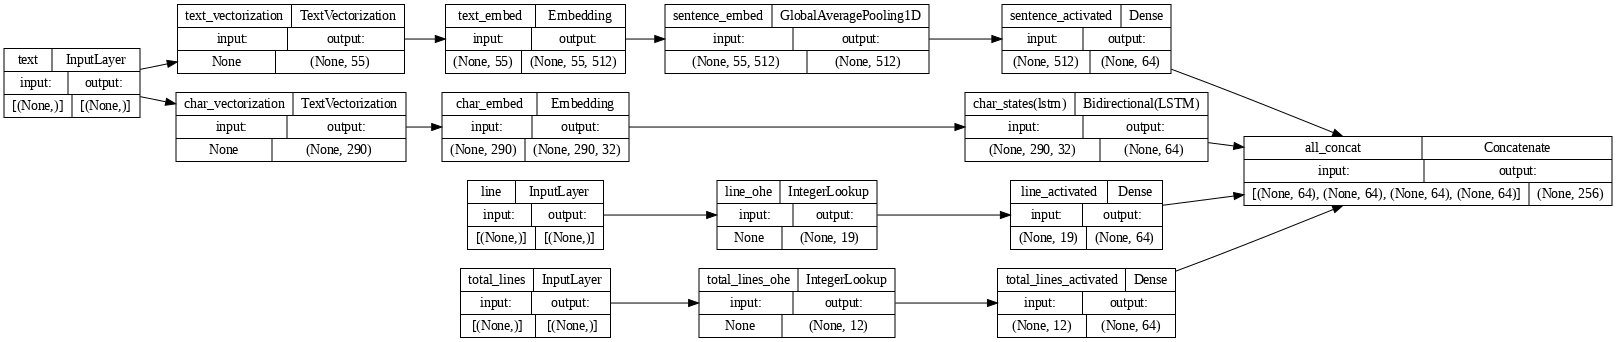

In [21]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings()
char_states = create_char_embeddings()
pos_embeddings = create_pos_ohe()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.extend(pos_embeddings)

bottom_model_0 = create_bottom_model("bottom_model_0", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_0, rankdir="LR", dpi=72, show_shapes=True)

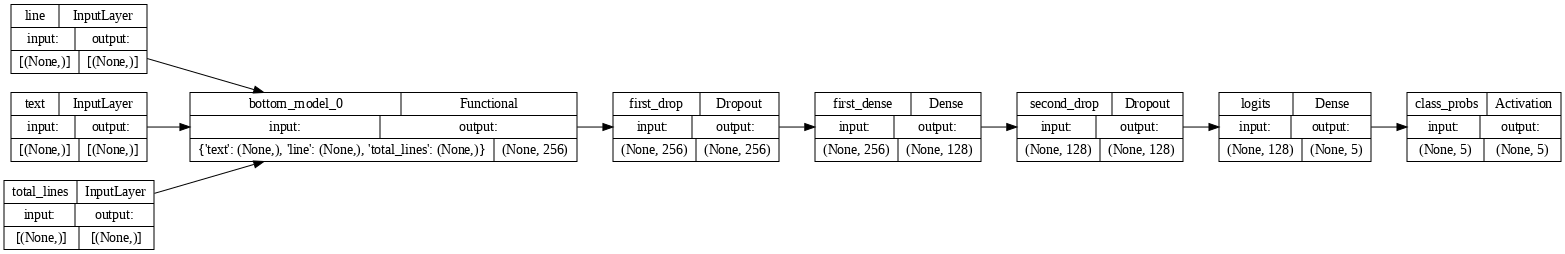

In [22]:
model_0 = create_model("model_0", bottom_model_0)

tf.keras.utils.plot_model(model = model_0, rankdir="LR", dpi=72, show_shapes=True)

How does label smoothing work?

Label smoothing introduces some noise into the one hot encoded labels.

With alpha=0.05, and 5 classes, the 1. becomes 0.96 and the 0.'s become 0.01.

In [23]:
y_true = np.array([0., 1., 0., 0., 0.])
alpha=0.01*len(LABELS)
y_true * np.array((1.0 - 0.05)) + np.array((0.05 / len(LABELS)))

array([0.01, 0.96, 0.01, 0.01, 0.01])

In [24]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                optimizer="adam",
                metrics=["accuracy"])

history_0 = model_0.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 64s 92ms/step - loss: 0.9295 - accuracy: 0.6673 - val_loss: 0.6149 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 21s 37ms/step - loss: 0.6692 - accuracy: 0.8117 - val_loss: 0.5791 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 20s 36ms/step - loss: 0.6287 - accuracy: 0.8278 - val_loss: 0.5596 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 20s 35ms/step - loss: 0.6171 - accuracy: 0.8341 - val_loss: 0.5435 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 19s 34ms/step - loss: 0.6107 - accuracy: 0.8377 - val_loss: 0.5449 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 21s 37ms/step - loss: 0.6084 - accuracy: 0.8356 - val_loss: 0.5336 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

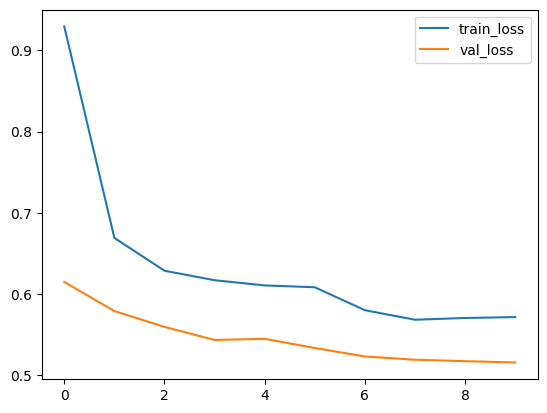

In [25]:
plt.plot(history_0.history["loss"], label="train_loss")
plt.plot(history_0.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

## model_1

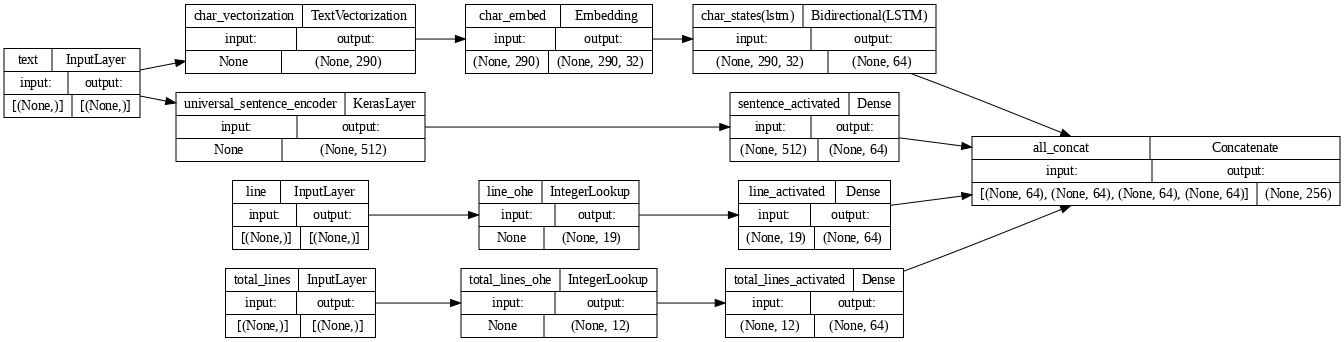

In [26]:
bottom_model_outputs = []

sentence_activated = create_use_embeddings()
char_states = create_char_embeddings()
pos_embeddings = create_pos_ohe()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.extend(pos_embeddings)

bottom_model_1 = create_bottom_model("bottom_model_1", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_1, rankdir="LR", dpi=72, show_shapes=True)

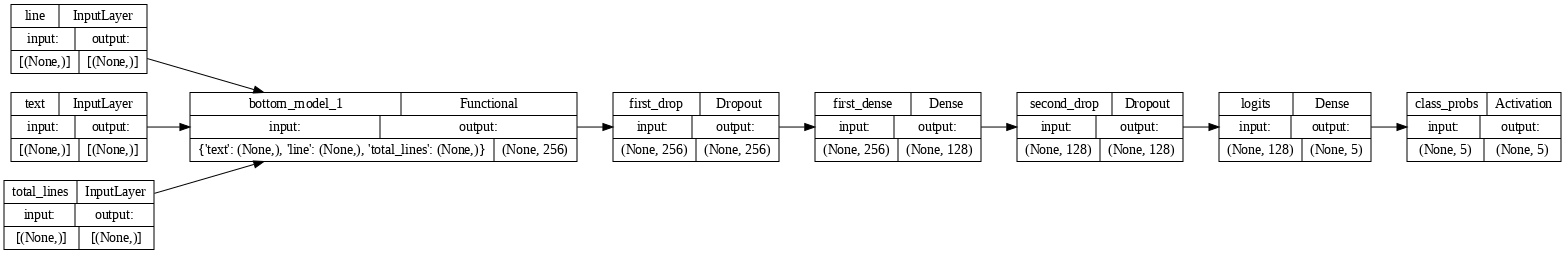

In [27]:
model_1 = create_model("model_1", bottom_model_1)

tf.keras.utils.plot_model(model = model_1, rankdir="LR", dpi=72, show_shapes=True)

In [28]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                optimizer="adam",
                metrics=["accuracy"])

history_1 = model_1.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 38s 51ms/step - loss: 0.9333 - accuracy: 0.6684 - val_loss: 0.6668 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 23s 40ms/step - loss: 0.7172 - accuracy: 0.7806 - val_loss: 0.6403 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 25s 45ms/step - loss: 0.6863 - accuracy: 0.7966 - val_loss: 0.6287 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 24s 43ms/step - loss: 0.6770 - accuracy: 0.8028 - val_loss: 0.5951 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 23s 40ms/step - loss: 0.6596 - accuracy: 0.8135 - val_loss: 0.5740 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 23s 41ms/step - loss: 0.6647 - accuracy: 0.8070 - val_loss: 0.5716 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

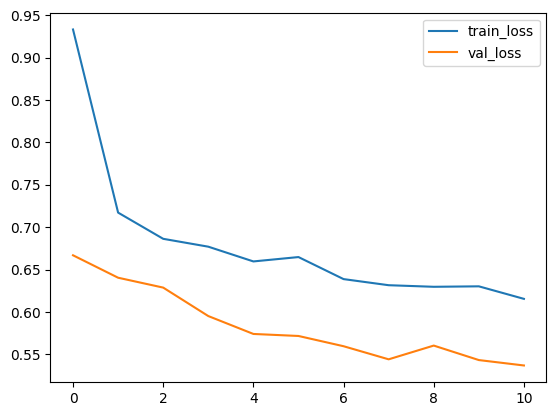

In [29]:
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [30]:
model_0_results = model_0.evaluate(dev_ds)
model_1_results = model_1.evaluate(dev_ds)

model_0_results, model_1_results

945/945 [==============================] - 21s 22ms/step - loss: 0.5484 - accuracy: 0.8553


([0.513513445854187, 0.8711439371109009],
 [0.5484120845794678, 0.8553223609924316])

`model_0` with trainable weights won. It's the one moving forward.

## model_2

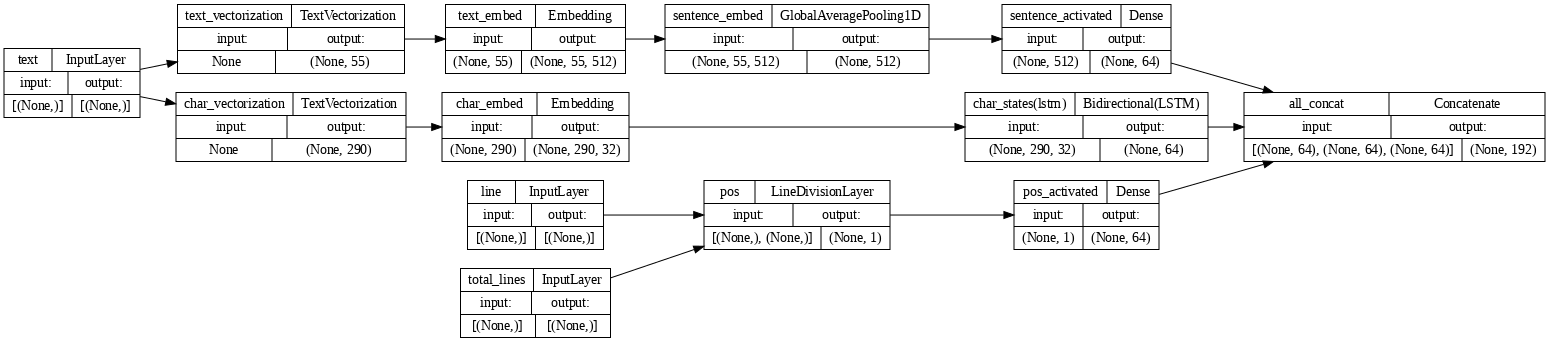

In [31]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings() # same as model_0
char_states = create_char_embeddings()
pos_floats = create_pos_float() # change compared to model_0

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.append(pos_floats)

bottom_model_2 = create_bottom_model("bottom_model_2", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_2, rankdir="LR", dpi=72, show_shapes=True)

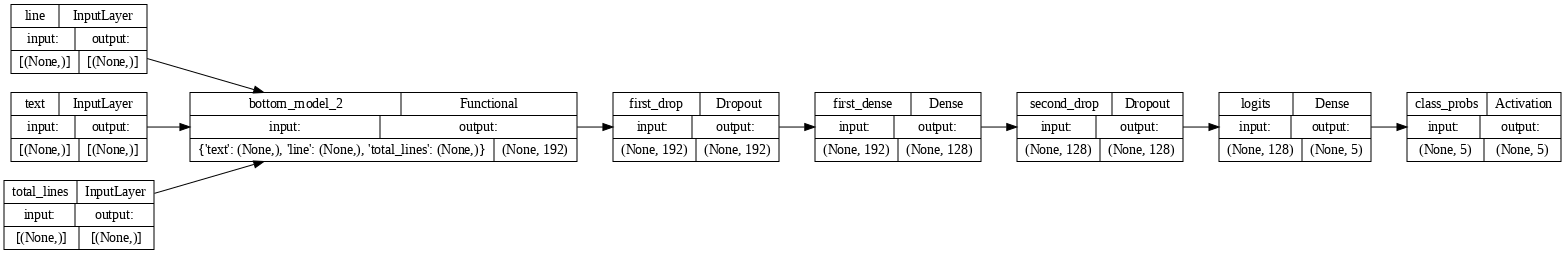

In [32]:
model_2 = create_model("model_2", bottom_model_2)

tf.keras.utils.plot_model(model = model_2, rankdir="LR", dpi=72, show_shapes=True)

In [33]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                optimizer="adam",
                metrics=["accuracy"])

history_2 = model_2.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 48s 72ms/step - loss: 0.9345 - accuracy: 0.6691 - val_loss: 0.6315 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 20s 35ms/step - loss: 0.6615 - accuracy: 0.8138 - val_loss: 0.5754 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 20s 35ms/step - loss: 0.6225 - accuracy: 0.8324 - val_loss: 0.5417 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 20s 35ms/step - loss: 0.6047 - accuracy: 0.8409 - val_loss: 0.5322 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 18s 32ms/step - loss: 0.5930 - accuracy: 0.8443 - val_loss: 0.5254 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 18s 31ms/step - loss: 0.5872 - accuracy: 0.8462 - val_loss: 0.5162 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

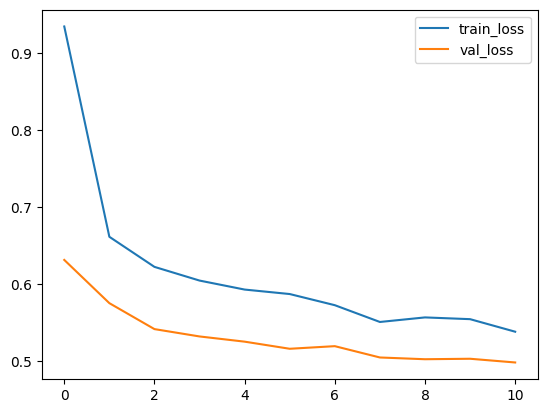

In [34]:
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [35]:
model_0_results = model_0.evaluate(dev_ds)
model_2_results = model_2.evaluate(dev_ds)

model_0_results, model_2_results

945/945 [==============================] - 14s 15ms/step - loss: 0.4970 - accuracy: 0.8807


([0.513513445854187, 0.8711439371109009],
 [0.4969617426395416, 0.8806765675544739])

`model_2` won by a very small margin. It's the one moving forward.

## model_3

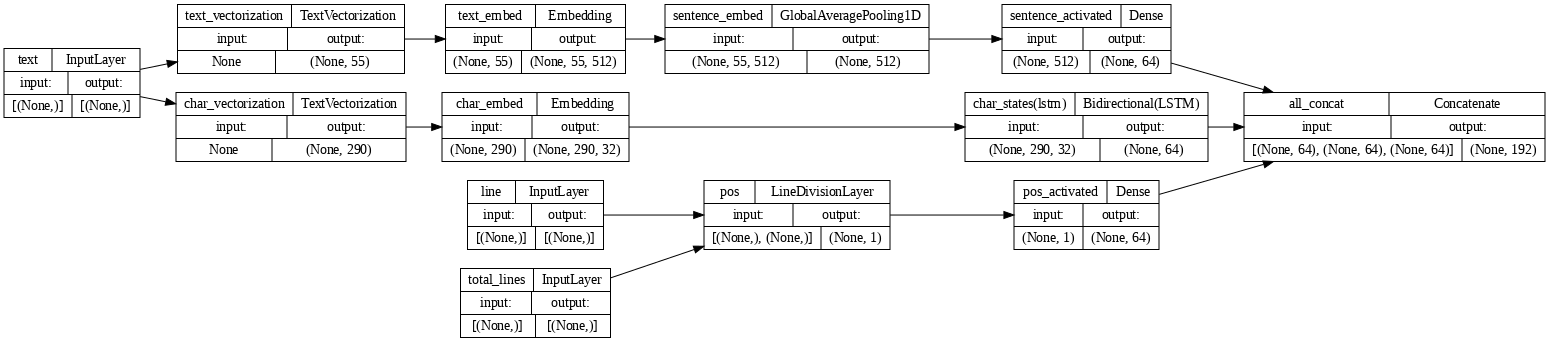

In [36]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings()
char_states = create_char_embeddings()
pos_floats = create_pos_float()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.append(pos_floats)

bottom_model_3 = create_bottom_model("bottom_model_3", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_3, rankdir="LR", dpi=72, show_shapes=True)

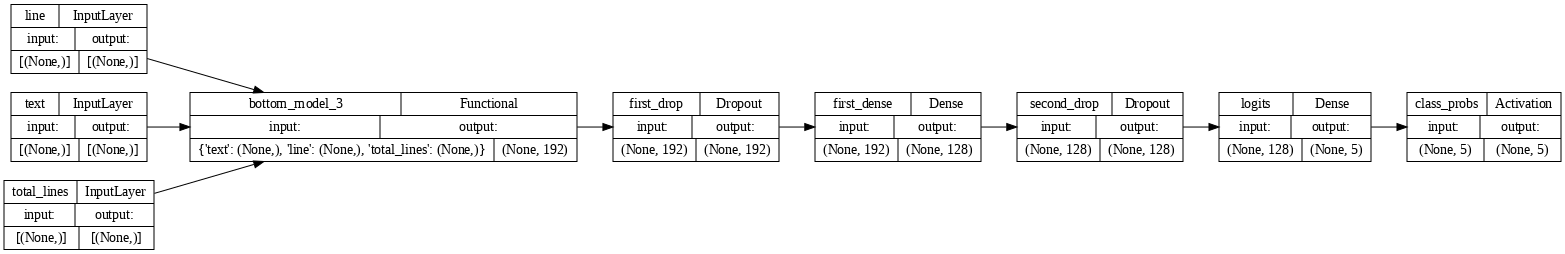

In [37]:
model_3 = create_model("model_3", bottom_model_3)

tf.keras.utils.plot_model(model = model_3, rankdir="LR", dpi=72, show_shapes=True)

In [38]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                optimizer="adam",
                metrics=["accuracy"])

history_3 = model_3.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        class_weight=balanced_class_weights, # change comapred to model_2
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 48s 72ms/step - loss: 1.0347 - accuracy: 0.5920 - val_loss: 0.6409 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 20s 35ms/step - loss: 0.7344 - accuracy: 0.7988 - val_loss: 0.6236 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 21s 38ms/step - loss: 0.7004 - accuracy: 0.8157 - val_loss: 0.5880 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 18s 31ms/step - loss: 0.6734 - accuracy: 0.8291 - val_loss: 0.5608 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 18s 32ms/step - loss: 0.6647 - accuracy: 0.8362 - val_loss: 0.5659 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 19s 33ms/step - loss: 0.6685 - accuracy: 0.8292 - val_loss: 0.5403 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

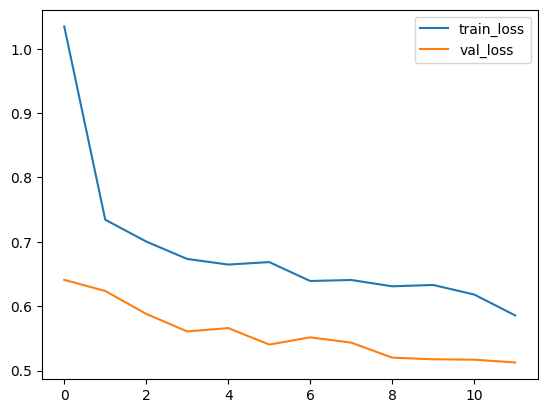

In [39]:
plt.plot(history_3.history["loss"], label="train_loss")
plt.plot(history_3.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [40]:
model_2_results = model_2.evaluate(dev_ds)
model_3_results = model_3.evaluate(dev_ds)

model_2_results, model_3_results

945/945 [==============================] - 14s 15ms/step - loss: 0.5165 - accuracy: 0.8756


([0.4969617426395416, 0.8806765675544739],
 [0.5164890289306641, 0.8755792379379272])

In [41]:
balanced_class_weights

{0: 1.657292769365306,
 1: 1.3253828032979977,
 2: 0.6066753154853166,
 3: 2.6019221041982803,
 4: 0.6213310786326851}

In [42]:
from tqdm.auto import tqdm

pbar = tqdm(dev_ds)

objective_precision = tf.keras.metrics.Precision(class_id=3)
objective_recall = tf.keras.metrics.Recall(class_id=3)

for batch_features, batch_labels in pbar:
  batch_preds = model_2.predict(batch_features, verbose=0)
  objective_precision.update_state(batch_labels, batch_preds)
  objective_recall.update_state(batch_labels, batch_preds)
  obj_pre = objective_precision.result().numpy()
  obj_rec = objective_recall.result().numpy()
  pbar.set_postfix({"Objective Precision": f"{obj_pre:.4f}",
                    "Objective Recall": f"{obj_rec:.4f}"})

  0%|          | 0/945 [00:00<?, ?it/s]

In [43]:
pbar = tqdm(dev_ds)

objective_precision = tf.keras.metrics.Precision(class_id=3)
objective_recall = tf.keras.metrics.Recall(class_id=3)

for batch_features, batch_labels in pbar:
  batch_preds = model_3.predict(batch_features, verbose=0)
  objective_precision.update_state(batch_labels, batch_preds)
  objective_recall.update_state(batch_labels, batch_preds)
  obj_pre = objective_precision.result().numpy()
  obj_rec = objective_recall.result().numpy()
  pbar.set_postfix({"Objective Precision": f"{obj_pre:.4f}",
                    "Objective Recall": f"{obj_rec:.4f}"})

  0%|          | 0/945 [00:00<?, ?it/s]

In terms of overall accuracy `model_2` wins over `model_3` by a small margin.

But `model_3` is better at detecting the OBJECTIVE class with a better PR trade off. 15pp increase in Recall (-15 FN) with a 10pp reduction in Precision (+10 FP).

## best model (full train)

In [44]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings()
char_states = create_char_embeddings()
pos_floats = create_pos_float()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.append(pos_floats)

bottom_model_best = create_bottom_model("bottom_model_best", bottom_model_outputs)

model_best = create_model("model_best", bottom_model_3)

model_best.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                   optimizer="adam",
                   metrics=["accuracy"])

history_best = model_best.fit(train_ds,
                              epochs=100,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=dev_ds,
                              validation_steps=int(0.1 * len(dev_ds)),
                              class_weight=balanced_class_weights,
                              callbacks=[early_stopping_callback, reduce_LR_callback]
                              )

Epoch 1/100
562/562 [==============================] - 47s 72ms/step - loss: 0.7680 - accuracy: 0.7926 - val_loss: 0.5638 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 21s 37ms/step - loss: 0.6399 - accuracy: 0.8464 - val_loss: 0.5710 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 18s 32ms/step - loss: 0.6322 - accuracy: 0.8533 - val_loss: 0.5499 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 17s 31ms/step - loss: 0.6149 - accuracy: 0.8621 - val_loss: 0.5356 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 20s 36ms/step - loss: 0.6135 - accuracy: 0.8568 - val_loss: 0.5375 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 19s 35ms/step - loss: 0.6160 - accuracy: 0.8553 - val_loss: 0.5254 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

## scikit-learn models

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [46]:
DATA_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

train_dict = examples_from_text_file(DATA_DIR + "train.txt", label_mode="str")
dev_dict = examples_from_text_file(DATA_DIR + "dev.txt", label_mode="str")
test_dict = examples_from_text_file(DATA_DIR + "test.txt", label_mode="str")

In [47]:
train_df = pd.DataFrame(train_dict)
dev_df = pd.DataFrame(dev_dict)
test_df = pd.DataFrame(test_dict)

train_df["pos"] = train_df["line"] / train_df["total_lines"]
dev_df["pos"] = dev_df["line"] / dev_df["total_lines"]
test_df["pos"] = test_df["line"] / test_df["total_lines"]

In [48]:
X_train = train_df[["text", "pos"]].copy()
y_train = train_df["label"].copy()

X_dev = dev_df[["text", "pos"]].copy()
y_dev = dev_df["label"].copy()

X_test = test_df[["text", "pos"]].copy()
y_test = test_df["label"].copy()

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

((180040, 2), (180040,), (30212, 2), (30212,), (30135, 2), (30135,))

In [49]:
preproc = ColumnTransformer([
    ("text", TfidfVectorizer(), "text"),
    ("pos", "passthrough", ["pos"])
])

svm = Pipeline([
    ("pre", preproc),
    ("clf", LinearSVC(class_weight="balanced"))
])

_ = svm.fit(X_train, y_train)

nb = Pipeline([
    ("pre", preproc),
    ("clf", MultinomialNB())
])

_ = nb.fit(X_train, y_train)

In [50]:
svm_y_pred = svm.predict(X_dev)
print(classification_report(y_dev, svm_y_pred))

              precision    recall  f1-score   support

  BACKGROUND       0.69      0.72      0.70      3449
 CONCLUSIONS       0.88      0.90      0.89      4582
     METHODS       0.89      0.90      0.89      9964
   OBJECTIVE       0.62      0.62      0.62      2376
     RESULTS       0.90      0.87      0.89      9841

    accuracy                           0.85     30212
   macro avg       0.80      0.80      0.80     30212
weighted avg       0.85      0.85      0.85     30212



In [51]:
nb_y_pred = nb.predict(X_dev)
print(classification_report(y_dev, nb_y_pred))

              precision    recall  f1-score   support

  BACKGROUND       0.68      0.54      0.60      3449
 CONCLUSIONS       0.72      0.63      0.67      4582
     METHODS       0.74      0.87      0.80      9964
   OBJECTIVE       0.78      0.16      0.26      2376
     RESULTS       0.76      0.87      0.81      9841

    accuracy                           0.74     30212
   macro avg       0.74      0.61      0.63     30212
weighted avg       0.74      0.74      0.72     30212



## Best of DL vs Best of non-DL

In [52]:
model_2_y_proba = model_best.predict(dev_ds)
model_2_y_pred = tf.argmax(model_2_y_proba, axis=1).numpy()
model_2_y_pred = pd.Series(label_lookup[p] for p in model_2_y_pred)
print(classification_report(y_dev, model_2_y_pred))

945/945 [==============================] - 14s 13ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.73      0.77      0.75      3449
 CONCLUSIONS       0.90      0.92      0.91      4582
     METHODS       0.93      0.92      0.92      9964
   OBJECTIVE       0.65      0.66      0.66      2376
     RESULTS       0.93      0.91      0.92      9841

    accuracy                           0.88     30212
   macro avg       0.83      0.84      0.83     30212
weighted avg       0.88      0.88      0.88     30212



In [53]:
print(classification_report(y_dev, svm_y_pred))

              precision    recall  f1-score   support

  BACKGROUND       0.69      0.72      0.70      3449
 CONCLUSIONS       0.88      0.90      0.89      4582
     METHODS       0.89      0.90      0.89      9964
   OBJECTIVE       0.62      0.62      0.62      2376
     RESULTS       0.90      0.87      0.89      9841

    accuracy                           0.85     30212
   macro avg       0.80      0.80      0.80     30212
weighted avg       0.85      0.85      0.85     30212



In [54]:
model_best.save("drive/MyDrive/PubMedProject/model/pubmed_abstract.tf")

# Exercise 2


2. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  * Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  * It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

In [55]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip glove.6B.zip -d /content/glove/
!head -n 10 /content/glove/glove.6B.50d.txt

--2023-10-08 17:04:52--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 13.32.121.101, 13.32.121.112, 13.32.121.124, ...
Connecting to huggingface.co (huggingface.co)|13.32.121.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1697043892&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NzA0Mzg5Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=lZh8ObMYmA2AYRwdde6lJTDsg

In [56]:
EMBEDDING_DIM = 300
GLOVE_FILE = f"/content/glove/glove.6B.{EMBEDDING_DIM}d.txt"

glove_embeddings = {}
with open(GLOVE_FILE) as file:
  for line in file:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype="float32")
    glove_embeddings[word] = vector

vocab = text_vec_layer.get_vocabulary()
print("Words not in Glove (hence, initialization='uniform'):", len(list(set(vocab) - set(glove_embeddings.keys()))))

def glove_init(shape, dtype=None):
  """Initialize using Glove embeddings if possible, else uniform."""
  embedding_matrix = np.zeros(shape)
  for i, word in enumerate(vocab):
    embedding_matrix[i] = glove_embeddings.get(word, np.random.uniform(size=(shape[1],)).astype("float32"))
  return tf.constant(embedding_matrix, dtype=dtype)

Words not in Glove (hence, initialization='uniform'): 1361


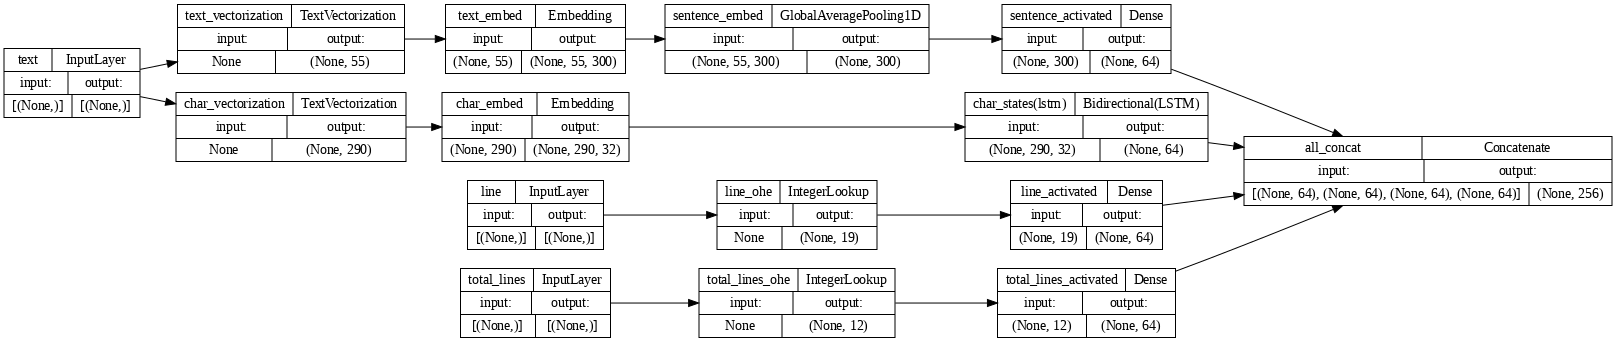

In [57]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings(init=glove_init)
char_states = create_char_embeddings()
pos_embeddings = create_pos_ohe()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.extend(pos_embeddings)

bottom_model_glove = create_bottom_model("bottom_model_glove", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_glove, rankdir="LR", dpi=72, show_shapes=True)

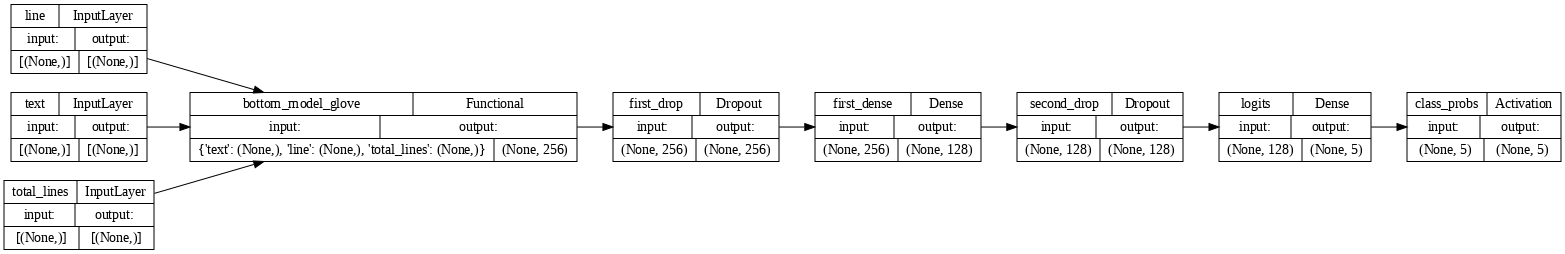

In [58]:
model_glove = create_model("model_glove", bottom_model_glove)

tf.keras.utils.plot_model(model = model_glove, rankdir="LR", dpi=72, show_shapes=True)

In [59]:
embedding_weights = bottom_model_glove.get_layer("text_embed").get_weights()[0]
sample_words = np.random.choice(list(set(vocab) & set(glove_embeddings.keys())), 10)
for word in sample_words:
    idx = vocab.index(word)
    model_embedding = embedding_weights[idx]
    glove_embedding = glove_embeddings[word]
    assert np.allclose(model_embedding, glove_embedding), f"Embeddings do not match for word: {word}"

In [60]:
model_glove.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01*len(LABELS)),
                optimizer="adam",
                metrics=["accuracy"])

history_glove = model_glove.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 57s 89ms/step - loss: 1.1577 - accuracy: 0.5409 - val_loss: 0.8501 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 22s 39ms/step - loss: 0.8717 - accuracy: 0.6989 - val_loss: 0.7345 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 19s 34ms/step - loss: 0.7999 - accuracy: 0.7360 - val_loss: 0.6684 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 18s 32ms/step - loss: 0.7519 - accuracy: 0.7661 - val_loss: 0.6474 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 20s 36ms/step - loss: 0.7273 - accuracy: 0.7796 - val_loss: 0.6004 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 21s 37ms/step - loss: 0.6958 - accuracy: 0.7977 - val_loss: 0.5889 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 7/100
562/562 [==============================]

# Exercise 3


3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  * Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf

In [61]:
import tensorflow_text as text

def create_bert_pubmed_embeddings():
  bert_pre = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="bert_preprocess")
  bert_emb = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2",
                            trainable=False,
                            output_key="default",
                            name="bert_embed")
  sentence_pre = bert_pre(inputs["text"])
  sentence_embed = bert_emb(sentence_pre, training=False)
  sentence_activated = tf.keras.layers.Dense(64, activation="relu",
                                            name="sentence_activated")(sentence_embed)
  return sentence_activated

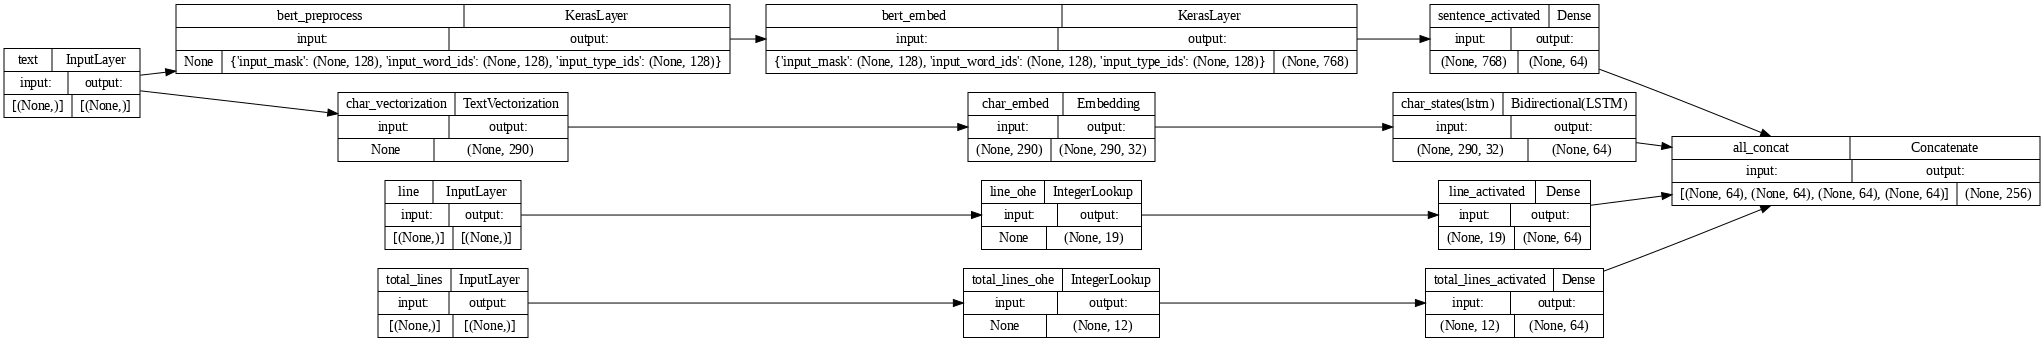

In [62]:
bottom_model_outputs = []

sentence_activated = create_bert_pubmed_embeddings()
char_states = create_char_embeddings()
pos_embeddings = create_pos_ohe()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.extend(pos_embeddings)

bottom_model_bert = create_bottom_model("bottom_model_bert", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_bert, rankdir="LR", dpi=72, show_shapes=True)

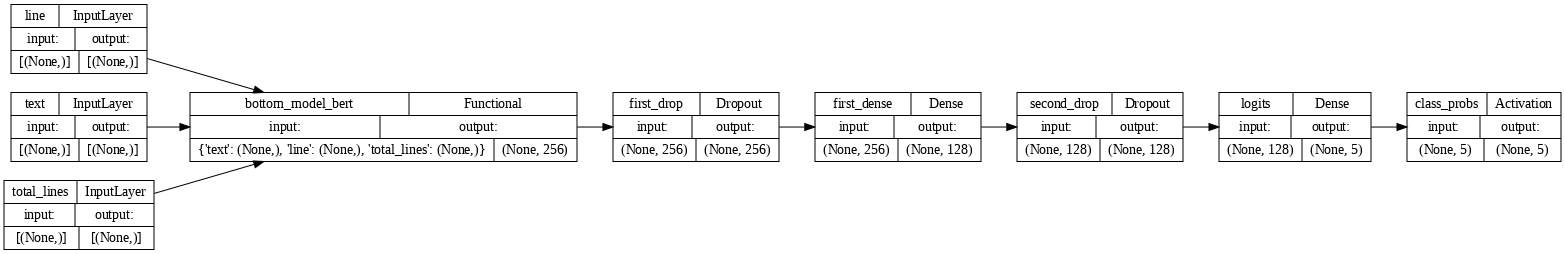

In [63]:
model_bert = create_model("model_bert", bottom_model_bert)

tf.keras.utils.plot_model(model = model_bert, rankdir="LR", dpi=72, show_shapes=True)

In [64]:
model_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01*len(LABELS)),
                optimizer="adam",
                metrics=["accuracy"])

history_bert = model_bert.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 263s 439ms/step - loss: 0.8331 - accuracy: 0.7446 - val_loss: 0.5675 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 234s 417ms/step - loss: 0.6422 - accuracy: 0.8334 - val_loss: 0.5366 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 245s 435ms/step - loss: 0.6153 - accuracy: 0.8427 - val_loss: 0.5126 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 248s 441ms/step - loss: 0.5927 - accuracy: 0.8539 - val_loss: 0.5152 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 244s 435ms/step - loss: 0.5869 - accuracy: 0.8555 - val_loss: 0.4955 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 235s 418ms/step - loss: 0.5861 - accuracy: 0.8538 - val_loss: 0.4869 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 7/100
562/562 [===================

# Exercise 4


4. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  * Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.

In [65]:
from itertools import product

lineof_vocab = []
tot_lines_range = range(min_total_lines, max_total_lines + 1)
for r in tot_lines_range:
  lineof_vocab.extend([str(a) + "_of_" + str(b) for a, b in list(product(range(1, r + 1), [r]))])
lineof_vocab[:3], "..." ,lineof_vocab[-3:]

(['1_of_8', '2_of_8', '3_of_8'], '...', ['17_of_19', '18_of_19', '19_of_19'])

In [66]:
class LineOfXLayer(tf.keras.layers.Layer):
  def call(self, inputs):
    a = tf.as_string(inputs[0])
    of = tf.constant("_of_")
    b = tf.as_string(inputs[1])
    a_of_b = a + of + b
    a_of_b_index = tf.keras.layers.StringLookup(vocabulary=lineof_vocab)(a_of_b)
    result = tf.keras.layers.CategoryEncoding(num_tokens=len(lineof_vocab) + 1,
                                              output_mode="one_hot")(a_of_b_index)
    return result

def create_line_of_X_ohe():
  pos = LineOfXLayer(name="line_of_X")([inputs["line"], inputs["total_lines"]])
  pos_activated = tf.keras.layers.Dense(64, activation="relu",
                                        name="pos_activated")(pos)
  return pos_activated

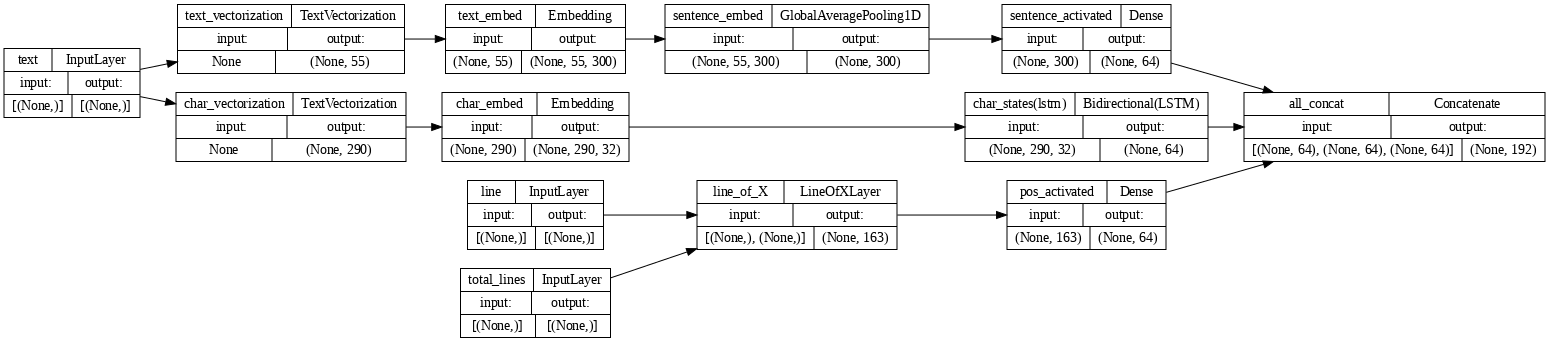

In [67]:
bottom_model_outputs = []

sentence_activated = create_trainable_embeddings()
char_states = create_char_embeddings()
pos_embeddings = create_line_of_X_ohe()

bottom_model_outputs.append(sentence_activated)
bottom_model_outputs.append(char_states)
bottom_model_outputs.append(pos_embeddings)

bottom_model_4 = create_bottom_model("bottom_model_4", bottom_model_outputs)

tf.keras.utils.plot_model(model = bottom_model_4, rankdir="LR", dpi=72, show_shapes=True)

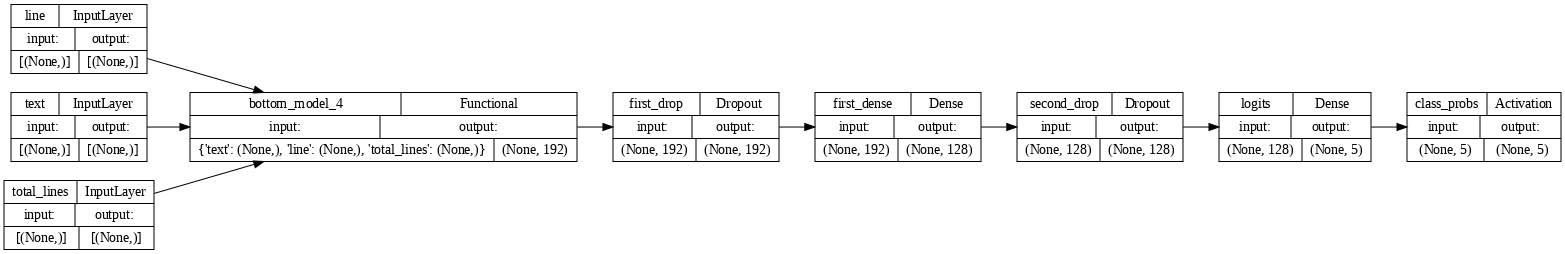

In [68]:
model_4 = create_model("model_4", bottom_model_4)

tf.keras.utils.plot_model(model = model_4, rankdir="LR", dpi=72, show_shapes=True)

In [69]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=alpha),
                optimizer="adam",
                metrics=["accuracy"])

history_4 = model_4.fit(train_ds,
                        epochs=100,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=dev_ds,
                        validation_steps=int(0.1 * len(dev_ds)),
                        callbacks=[early_stopping_callback, reduce_LR_callback]
                        )

Epoch 1/100
562/562 [==============================] - 47s 71ms/step - loss: 1.0120 - accuracy: 0.6242 - val_loss: 0.6191 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 2/100
562/562 [==============================] - 20s 36ms/step - loss: 0.6611 - accuracy: 0.8115 - val_loss: 0.5679 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 3/100
562/562 [==============================] - 18s 32ms/step - loss: 0.6199 - accuracy: 0.8304 - val_loss: 0.5422 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 4/100
562/562 [==============================] - 17s 30ms/step - loss: 0.6039 - accuracy: 0.8425 - val_loss: 0.5335 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 5/100
562/562 [==============================] - 17s 30ms/step - loss: 0.6000 - accuracy: 0.8440 - val_loss: 0.5247 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 6/100
562/562 [==============================] - 19s 34ms/step - loss: 0.5951 - accuracy: 0.8420 - val_loss: 0.5246 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/100
562/562 [==============================]